In [1]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from lib.acoustic_model import AcousticModel
import lib.dataset as dataset
from lib.opt import optimize
import lib.media as media

In [2]:
os.environ['CUDA_DEVICE_ORDER']='PCI_BUS_ID'   # see issue #152
os.environ['CUDA_VISIBLE_DEVICES']='1'

checkpoint_dir = '_conv8192_adam'
window = 8192

In [8]:
train_set = dataset.OrcaDataset(root='data', train=True, window=window, stride=8192)
test_set = dataset.OrcaDataset(root='data', train=False, window=window)

Loaded dataset with 8074 datapoints
Loaded dataset with 25853 datapoints


In [9]:
class Model(AcousticModel):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        
    def define_graph(self, debug=False):
        self.m = 1
        self.k = 512
        self.d = 1024
        self.stride = 512
        self.regions = 1 + int(window - self.d)//self.stride
        
        self.wsin, self.wcos = self.create_filters(self.d,self.k)
        
        self.conv = nn.Sequential(            
            nn.Conv2d(1,64,(33,1),padding=(16,0),bias=False),nn.ReLU(True),
            nn.Conv2d(64,64,(33,1),padding=(16,0),bias=False),nn.ReLU(True),
            nn.Conv2d(64,64,(33,1),padding=(16,0),bias=False),nn.ReLU(True),
            nn.Conv2d(64,8,(512,1),bias=False),nn.ReLU(True)
        )
        
        self.out = nn.Linear(self.regions*8,self.m,bias=True)
    
    def forward(self, x, y):
        zx = F.conv1d(x[:,None,:], self.wsin, stride=self.stride).pow(2) \
           + F.conv1d(x[:,None,:], self.wcos, stride=self.stride).pow(2)
        return self.out(self.conv(zx.unsqueeze(1)).view(-1,self.regions*8))

In [10]:
model = Model(checkpoint_dir, avg=.9, weight_scale=0.0001)
model.initialize()

conv.0.weight torch.Size([64, 1, 33, 1]) (2112)
conv.2.weight torch.Size([64, 64, 33, 1]) (135168)
conv.4.weight torch.Size([64, 64, 33, 1]) (135168)
conv.6.weight torch.Size([8, 64, 512, 1]) (262144)
out.weight torch.Size([1, 120]) (120)
out.bias torch.Size([1]) (1)
Initialized graph with 534713 parameters


In [11]:
optimize(model,train_set,test_set,learning_rate=0.001,batch_size=256,workers=4,alg='Adam')

Initiating optimizer, 32 iterations/epoch.
avp_tr	avp_ts	iter	loss_tr	loss_ts	time	utime
34.93   14.68   0       0.175   0.073   6.81    6.49    
34.93   14.68   32      0.164   0.069   22.39   6.53    
27.18   11.10   64      0.135   0.080   22.60   6.57    
51.08   38.33   96      0.111   0.067   22.55   6.62    
67.41   58.08   128     0.097   0.055   22.47   6.49    
70.23   59.64   160     0.091   0.049   22.55   6.58    
71.14   60.65   192     0.089   0.049   22.55   6.57    
72.67   60.73   224     0.088   0.047   22.76   6.72    
72.73   61.82   256     0.088   0.048   22.48   6.56    
71.76   62.37   288     0.087   0.048   22.53   6.57    
73.62   63.43   320     0.089   0.048   22.56   6.56    
74.37   63.31   352     0.084   0.047   22.71   6.63    
76.92   65.01   384     0.082   0.047   22.54   6.57    
76.05   64.28   416     0.082   0.046   22.68   6.69    
75.99   64.89   448     0.082   0.048   22.53   6.49    
78.22   66.06   480     0.079   0.048   22.57   6.58    

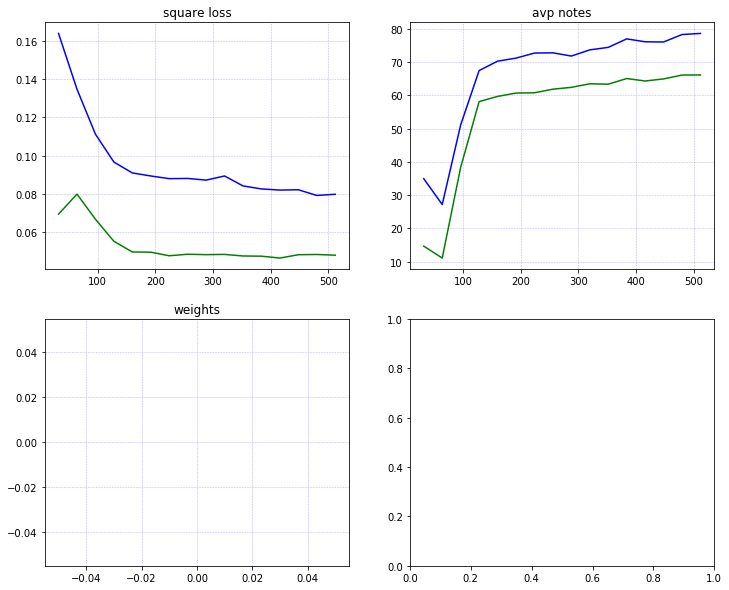

In [12]:
model.restore_checkpoint()
plt = media.PlotFormatter()
plt.plot('square loss',model.stats['loss_tr'][2],color='b')
plt.plot('square loss',model.stats['loss_ts'][2],color='g',share=True)
plt.plot('avp notes',model.stats['avp_tr'][2],color='b')
plt.plot('avp notes',model.stats['avp_ts'][2],color='g',share=True)
plt.plot('weights',model.sum_weights('beta'),color='g')
plt.show()

In [13]:
test_loader = torch.utils.data.DataLoader(dataset=test_set,batch_size=256,drop_last=False,**dataset.worker_config)
yhat,y = model.predict_all(test_loader)

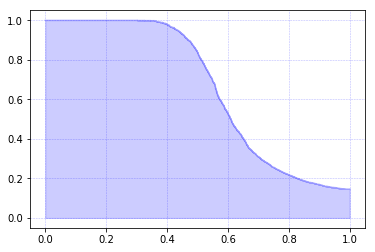

In [14]:
media.plot_pr_curve(y,yhat)

In [18]:
from sklearn.metrics import precision_recall_fscore_support
p,r,f,_ = precision_recall_fscore_support(y.ravel(),yhat.ravel()>.35,average='binary')
print(p,r,f)

0.9000504795557799 0.46995255666842384 0.6174891774891774
